## Image processing

This notbooks aims at cleaning measured intensities noise from available records.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import speckleret
import speckleret.utils

### Load and convert dataset

In [2]:
data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


In [3]:
CP = speckleret.utils.nested_arrays_to_ndarray(CP)
CL = speckleret.utils.nested_arrays_to_ndarray(CL)

print(CP.shape)
print(CL.shape)

(1, 100, 801, 801)
(1, 100, 512, 512)


### Normalize and get centroids

In [6]:
mean_abs_CP = np.mean(CP, axis=(0,1))
mean_abs_CL = np.mean(CL, axis=(0,1))

mean_abs_CP_norm = mean_abs_CP / np.max(mean_abs_CP)
mean_abs_CL_norm = mean_abs_CL / np.max(mean_abs_CL)

(405.38801417479704, 412.8652624188786) (250.86981550352706, 250.53075926599465)


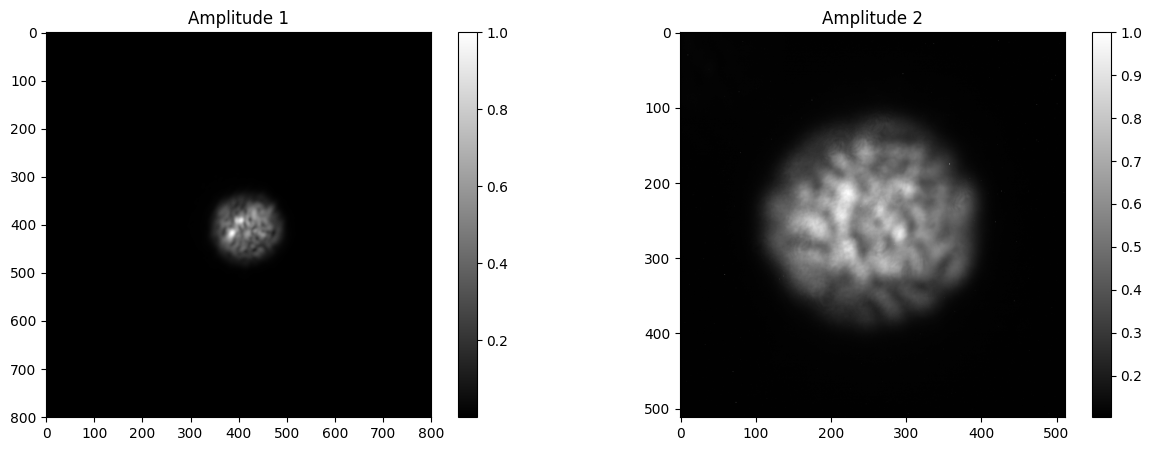

In [8]:
centroid_CP = speckleret.utils.get_centroid(np.square(mean_abs_CP_norm))
centroid_CL = speckleret.utils.get_centroid(np.square(mean_abs_CL_norm))
print(centroid_CP, centroid_CL)

_ = speckleret.plots.compare_arrays(mean_abs_CP_norm, mean_abs_CL_norm)

### Define a threshold mask over the average intensity

In [9]:
mask_CL = speckleret.utils.make_threshold_mask(np.square(mean_abs_CL_norm), threshold=0.02)
mask_CP = speckleret.utils.make_threshold_mask(np.square(mean_abs_CP_norm), threshold=0.01)

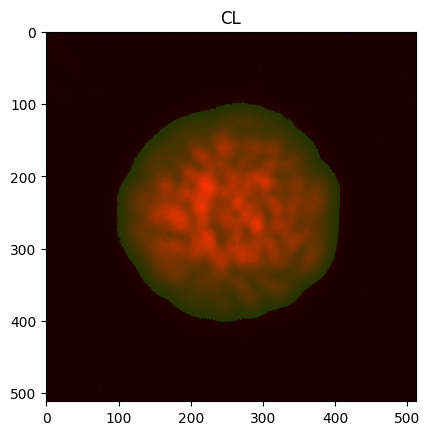

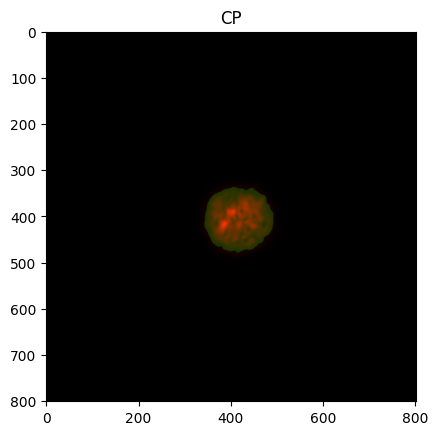

In [10]:
speckleret.plots.rgb_imshow([mean_abs_CL_norm, mask_CL*0.2], normalize_channels=False)
plt.title("CL")
plt.show()

speckleret.plots.rgb_imshow([mean_abs_CP_norm, mask_CP*0.2], normalize_channels=False)
plt.title("CP")
plt.show()

### Plot intensities distibutions in and out of the masks

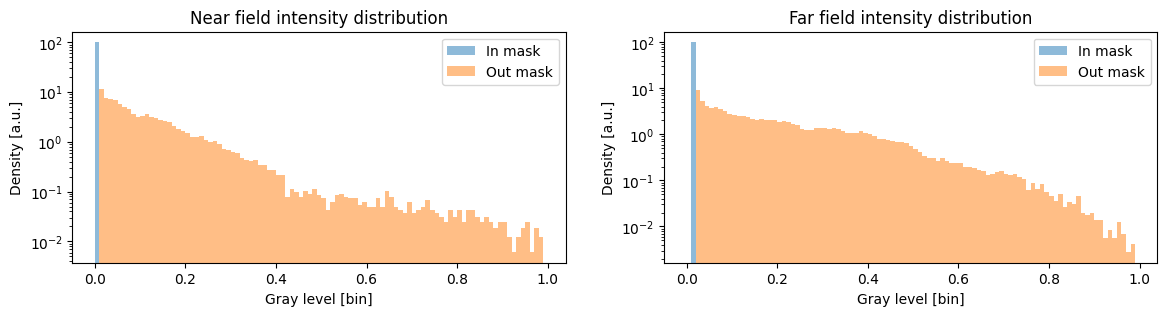

In [11]:
bins = np.arange(0, 1, 0.01)
density = True

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(np.square(mean_abs_CP_norm[np.logical_not(mask_CP)]), density=density, bins=bins, ls='None', alpha=0.5, label='In mask')
axs[0].hist(np.square(mean_abs_CP_norm[mask_CP]), density=density, bins=bins, ls='None', alpha=0.5, label='Out mask')
axs[0].set_title("Near field intensity distribution")
axs[0].set_xlabel("Gray level [bin]")
axs[0].set_ylabel("Density [a.u.]")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(np.square(mean_abs_CL_norm[np.logical_not(mask_CL)]), density=density, bins=bins, ls='None', alpha=0.5, label='In mask')
axs[1].hist(np.square(mean_abs_CL_norm[mask_CL]), density=density, bins=bins, ls='None', alpha=0.5, label='Out mask')
axs[1].set_title("Far field intensity distribution")
axs[1].set_xlabel("Gray level [bin]")
axs[1].set_ylabel("Density [a.u.]")
axs[1].set_yscale('log')
axs[1].legend()

### Correct intensities based on the noise average outside the mask

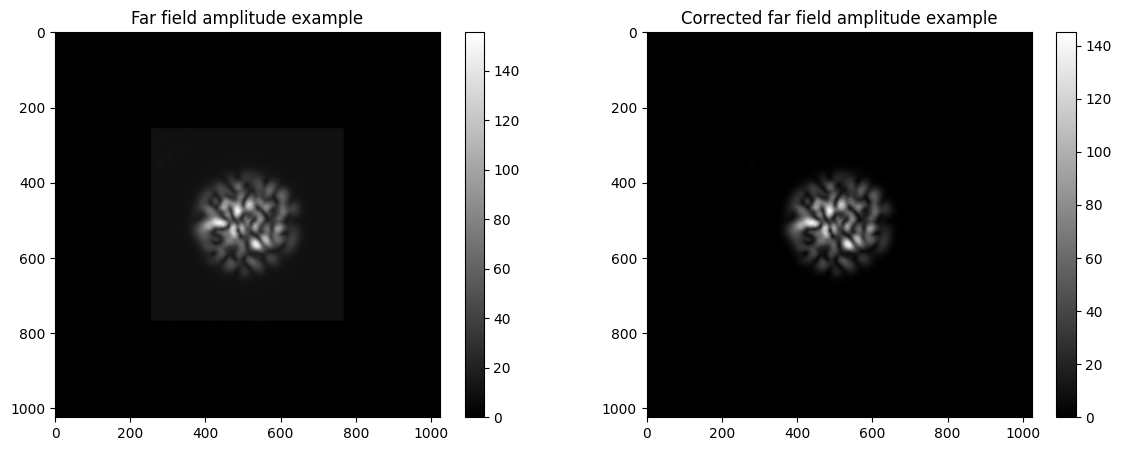

In [29]:
mean_noise_CL = np.mean(np.abs(CL) * np.reshape(mask_CL, ((1, 1) + mask_CL.shape)))
CL_corr = np.abs(CL - mean_noise_CL)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
pl0 = axs[0].imshow(speckleret.transforms.pad_img(CL[0, 0, :, :], pad=1), cmap='gray')
pl1 = axs[1].imshow(speckleret.transforms.pad_img(CL_corr[0, 0, :, :], pad=1), cmap='gray')
axs[0].set_title("Far field amplitude example")
axs[1].set_title("Corrected far field amplitude example")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])

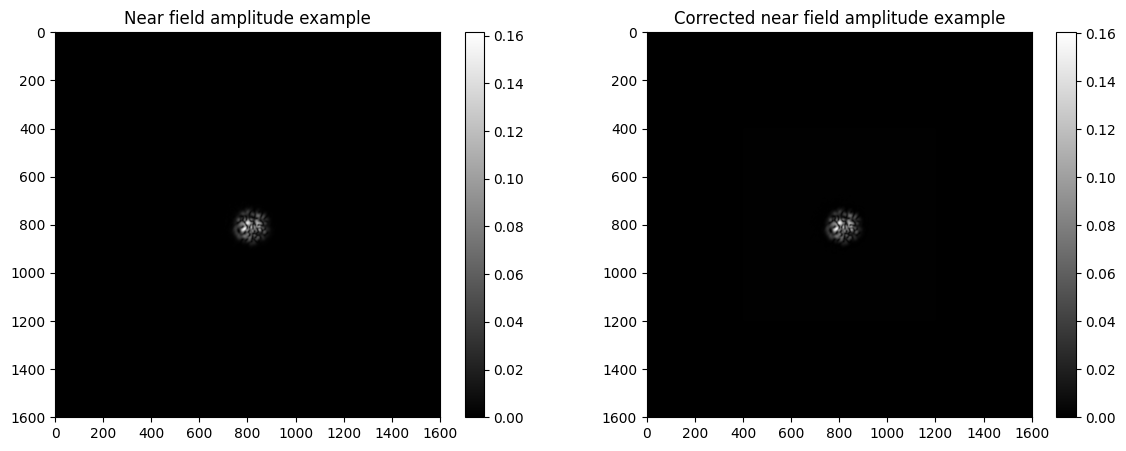

In [30]:
mean_noise_CP = np.mean(np.abs(CP) * np.reshape(mask_CP, ((1, 1) + mask_CP.shape)))
CP_corr = np.abs(CP - mean_noise_CP)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
pl0 = axs[0].imshow(speckleret.transforms.pad_img(CP[0, 0, :, :], pad=1), cmap='gray')
pl1 = axs[1].imshow(speckleret.transforms.pad_img(CP_corr[0, 0, :, :], pad=1), cmap='gray')
axs[0].set_title("Near field amplitude example")
axs[1].set_title("Corrected near field amplitude example")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])

### Compute and plot the contrasts before and after noise correction

In [95]:
square = False
contrast_CL = speckleret.utils.calculate_contrast(np.abs(CL[:, :, mask_CL]), axis=(2,), square=square)
contrast_CP = speckleret.utils.calculate_contrast(np.abs(CP[:, :, mask_CP]), axis=(2,), square=square)
contrast_CL_corr = speckleret.utils.calculate_contrast(np.abs(CL_corr[:, :, mask_CL]), axis=(2,), square=square)
contrast_CP_corr = speckleret.utils.calculate_contrast(np.abs(CP_corr[:, :, mask_CP]), axis=(2,), square=square)

print(np.min(contrast_CL), np.max(contrast_CL))
print(np.min(contrast_CL_corr), np.max(contrast_CL_corr))
print(np.min(contrast_CP), np.max(contrast_CP))
print(np.min(contrast_CP_corr), np.max(contrast_CP_corr))

0.8431828014758223 0.9121347654544298
0.9962735456271649 0.9998946950635572
0.992576663557441 0.9998534105661251
0.9984881154741815 0.9999997588041166


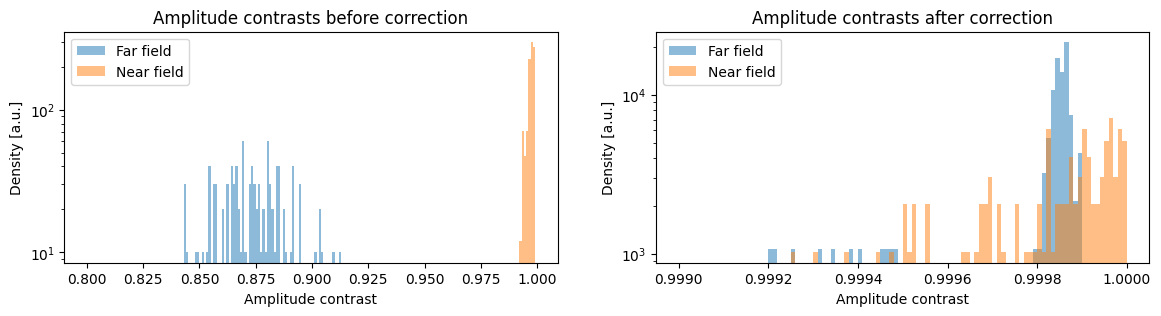

In [96]:
bins1 = np.arange(0.8, 1, 0.001)
bins2 = np.arange(0.999, 1, 0.00001)
density = True

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(contrast_CL.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='Far field')
axs[0].hist(contrast_CP.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='Near field')
axs[0].set_title("Amplitude contrasts before correction")
axs[0].set_xlabel("Amplitude contrast")
axs[0].set_ylabel("Density [a.u.]")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(contrast_CL_corr.flatten(), density=density, bins=bins2, ls='None', alpha=0.5, label='Far field')
axs[1].hist(contrast_CP_corr.flatten(), density=density, bins=bins2, ls='None', alpha=0.5, label='Near field')
axs[1].set_title("Amplitude contrasts after correction")
axs[1].set_xlabel("Amplitude contrast")
axs[1].set_ylabel("Density [a.u.]")
axs[1].set_yscale('log')
axs[1].legend()

### Compute and plot the energies inside the mask before and after noise correction

In [84]:
energies_CL_mask = np.sum(np.square(np.abs(CL[:, :, mask_CL])), axis=2) / np.sum(np.square(np.abs(CL[:, :, ...])), axis=(2,3))
energies_CP_mask = np.sum(np.square(np.abs(CP[:, :, mask_CP])), axis=2) / np.sum(np.square(np.abs(CP[:, :, ...])), axis=(2,3))
energies_CL_corr_mask = np.sum(np.square(np.abs(CL_corr[:, :, mask_CL])), axis=2) / np.sum(np.square(np.abs(CL_corr[:, :, ...])), axis=(2,3))
energies_CP_corr_mask = np.sum(np.square(np.abs(CP_corr[:, :, mask_CP])), axis=2) / np.sum(np.square(np.abs(CP_corr[:, :, ...])), axis=(2,3))

print(np.min(energies_CL_mask), np.max(energies_CL_mask))
print(np.min(energies_CL_corr_mask), np.max(energies_CL_corr_mask))
print(np.min(energies_CP_mask), np.max(energies_CP_mask))
print(np.min(energies_CP_corr_mask), np.max(energies_CP_corr_mask))

0.8346389348827619 0.9000373587698172
0.9984530344808036 0.9993880389816654
0.9818897186897266 0.9950861253648585
0.955795535850631 0.9829780402594827


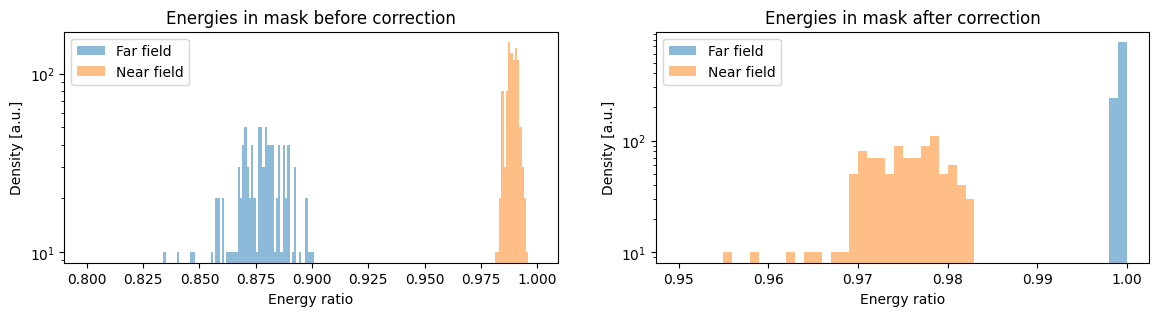

In [86]:
bins1 = np.arange(0.8, 1, 0.001)
bins2 = np.arange(0.95, 1, 0.001)
density = True

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(energies_CL_mask.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='Far field')
axs[0].hist(energies_CP_mask.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='Near field')
axs[0].set_title("Energies in mask before correction")
axs[0].set_xlabel("Energy ratio")
axs[0].set_ylabel("Density [a.u.]")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(energies_CL_corr_mask.flatten(), density=density, bins=bins2, ls='None', alpha=0.5, label='Far field')
axs[1].hist(energies_CP_corr_mask.flatten(), density=density, bins=bins2, ls='None', alpha=0.5, label='Near field')
axs[1].set_title("Energies in mask after correction")
axs[1].set_xlabel("Energy ratio")
axs[1].set_ylabel("Density [a.u.]")
axs[1].set_yscale('log')
axs[1].legend()